# Milan AirBnB Exploratory data analysis  
An exercise developed for CodeOp Module 3 milestone  

- Author: Margherita Serena Ferrara  
- Date: 25/11/2023  
- Contact: margheritaserena.ferrara@gmail.com

## Introduction  

This notebook illustrates an exploratory data analysis performed on the Milan AirBnB listings datasets provided by [Inside AirBnB](http://insideairbnb.com/). 
In particular for the purpose of this analysis, two datasets have been used:
- listings: list of available listings in the city as of September 2023
- calendar: listings availability and prices between September 2023 and September 2024

### Preliminary steps
The data used is collected and already processed by Inside AirBnB. However, some additional cleaning steps have been implemented for the purpose of this analysis.  
In particular, I have implemented the following cleaning steps:
- **removing entries which have a missing entry in the column bedroom**. AirBnB allows to select listings that have one or more bedrooms. It would have been reasonable to assume that listings with NA bedroom would be shared rooms (eg hostels). However, the data shows that most of these entries are actually recorded under 'Private rooms'. Since Inside AirBnB does not provide and explanation for such entries, I have disregarded these observations.
- **removing outliers in terms of prices.** It was found that some listings were recorded with extremely high prices per night (the highest was recorded with a price of €90,000). Having researched on AirBnb the higest listing prices, I found that the most expensive one was listed for €2,000 per night. I have therefore used removed those observations with a price above €2,500. 


### Main findings

### Next steps

[main steps]
- data cleaning: removing NAs (bedrooms)
- removing outliers price in both datasets

[distr of listings and price across Milan's enighbouhoods]:
findings: pta venezia ecc wuith highest n of listings  
duomo e brera highest mean price

[corr of price]
- bedrooms  
- type of room

[price over time]
- upwards trend

## [main findings]

## Section 1: Import data & clean data

[which files we import]

### [Set up]

In [1]:
# Import revelant packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import folium
import os
from folium.plugins import HeatMap

In [2]:
# Get folder paths
analysis_directory = os.getcwd()
parent_folder = os.path.dirname(analysis_directory)

### Listings  
[dataset shoudl contain all listings in Milan]

#### Import dataset

In [3]:
listings = pd.read_csv(parent_folder+'/MI AirBnB - dataset/listings.csv', delimiter = ',')

#### Explore data available
[identify varuiables of interest,
check whether variables need cleaning (NAs, weird symbols, convert in str/date etc)
]

In [4]:
# Explore the data
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24177 entries, 0 to 24176
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            24177 non-null  int64  
 1   listing_url                                   24177 non-null  object 
 2   scrape_id                                     24177 non-null  int64  
 3   last_scraped                                  24177 non-null  object 
 4   source                                        24177 non-null  object 
 5   name                                          24177 non-null  object 
 6   description                                   23761 non-null  object 
 7   neighborhood_overview                         13101 non-null  object 
 8   picture_url                                   24177 non-null  object 
 9   host_id                                       24177 non-null 

##### Unique identifier  
[helpful to have unique identifier in teh dataset.
expert to be id]
we know there are 24177 entries

In [5]:
listings['id'].nunique() == listings.shape[0]

True

conclusion: all is good

#### Missing values
[description]

##### Drop fully missing variables
info() suggests that some variables are fully missing (such as neighbourhood). 
We drop these.

In [6]:
listings = listings.dropna(axis=1, how='all')

##### Explore other variables that contain NAs

In [7]:
listings.columns[listings.isna().any()]

Index(['description', 'neighborhood_overview', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'neighbourhood',
       'bathrooms_text', 'bedrooms', 'beds', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'reviews_per_month'],
      dtype='object')

One of the variables that contain NA values is 'bedrooms'
Explore this further

In [8]:
listings['bedrooms'].value_counts(dropna=False)


bedrooms
1.0     14361
NaN      5430
2.0      3657
3.0       587
4.0       103
5.0        27
6.0         5
7.0         3
10.0        2
8.0         1
11.0        1
Name: count, dtype: int64

In [9]:
listings.groupby('room_type')['bedrooms'].value_counts(dropna=False)

room_type        bedrooms
Entire home/apt  1.0         13972
                 2.0          3642
                 NaN          1402
                 3.0           584
                 4.0           102
                 5.0            23
                 6.0             3
                 10.0            2
                 7.0             1
                 8.0             1
Hotel room       1.0            24
                 3.0             2
                 5.0             1
                 2.0             1
Private room     NaN          3762
                 1.0           365
                 2.0            14
                 5.0             3
                 7.0             2
                 6.0             2
                 3.0             1
                 4.0             1
                 11.0            1
Shared room      NaN           266
Name: count, dtype: int64

5430 listings are registered with 0 bedrooms.
AirBnB website allows to select listings that have 1 or more bedrooms. 1 bedrooms listings also include studios.
> Decision: drop these observations

In [10]:
#Store these observations in another dataset
listings_no_bedroom = listings[listings['bedrooms'].isna()]

listings = listings.dropna(subset=['bedrooms'])
# Check that observations have been dropped
listings[listings['bedrooms'].isna()]

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month


Go back to list of NA variables

In [11]:
listings.columns[listings.isna().any()]

Index(['description', 'neighborhood_overview', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'neighbourhood',
       'bathrooms_text', 'beds', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'reviews_per_month'],
      dtype='object')

they seem okay

#### Format variables
[description]

based on listings info notice two formatting to do:
price
calendar_last_scraped - not interested  

we explore price

In [12]:
listings['price']

1        $150.00
2        $171.00
3         $40.00
4         $94.00
6        $220.00
          ...   
24172     $90.00
24173    $119.00
24174    $113.00
24175     $83.00
24176     $96.00
Name: price, Length: 18747, dtype: object

need to remove dollar sign and convert into float

In [13]:
listings['price'] = listings['price'].str.replace('$', '')
# The variable price can't be immediately converted as float because the symbol ',' is not considered numerical.
listings['price'] = listings['price'].str.replace(',', '').astype(float)

# Note: quicker way to achieve this would have been with 
#   calendar['adjusted_price'] = calendar['adjusted_price'].replace('[$,]', '', regex=True).astype(float)

[conclusion: initial data cleaning of dataset listings is completed]

#### Outliers

Explore price to identify outliers

<Axes: ylabel='price'>

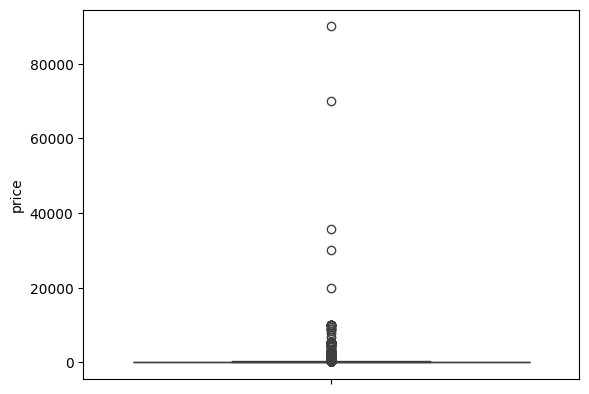

In [14]:
sns.boxplot(
    data = listings,
    y = 'price'
)

In [15]:
listings['price'].describe()

count    18747.00000
mean       206.14333
std        989.37974
min         10.00000
25%         90.00000
50%        128.00000
75%        200.00000
max      90000.00000
Name: price, dtype: float64

In [16]:
listings['price'].median()

128.0

Looked on airbnb and Milan's most expensive listing on the website (available any time) is around 2000.
Use 3000 as threshold

In [17]:
listings_no_outliers = listings[listings['price'] <= 3000]

<Axes: ylabel='price'>

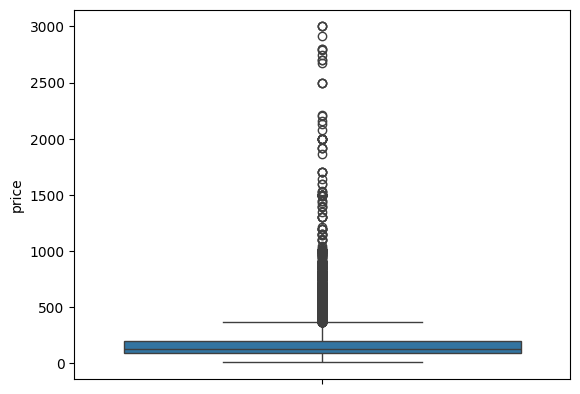

In [18]:
sns.boxplot(
    data = listings_no_outliers,
    y = 'price'
)

Still odd.
Use Inter quartile rule

In [19]:
# Calculate the IQR (Interquartile Range)
Q1 = listings['price'].quantile(0.25)
Q3 = listings['price'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to exclude outliers
listings_no_outliers = listings[(listings['price'] >= lower_bound) & (listings['price'] <= upper_bound)]

In [63]:
listings_no_outliers['price'].describe()

count    17358.000000
mean       140.144256
std         70.348757
min         10.000000
25%         90.000000
50%        120.000000
75%        177.000000
max        365.000000
Name: price, dtype: float64

Visualise how data distribution changed

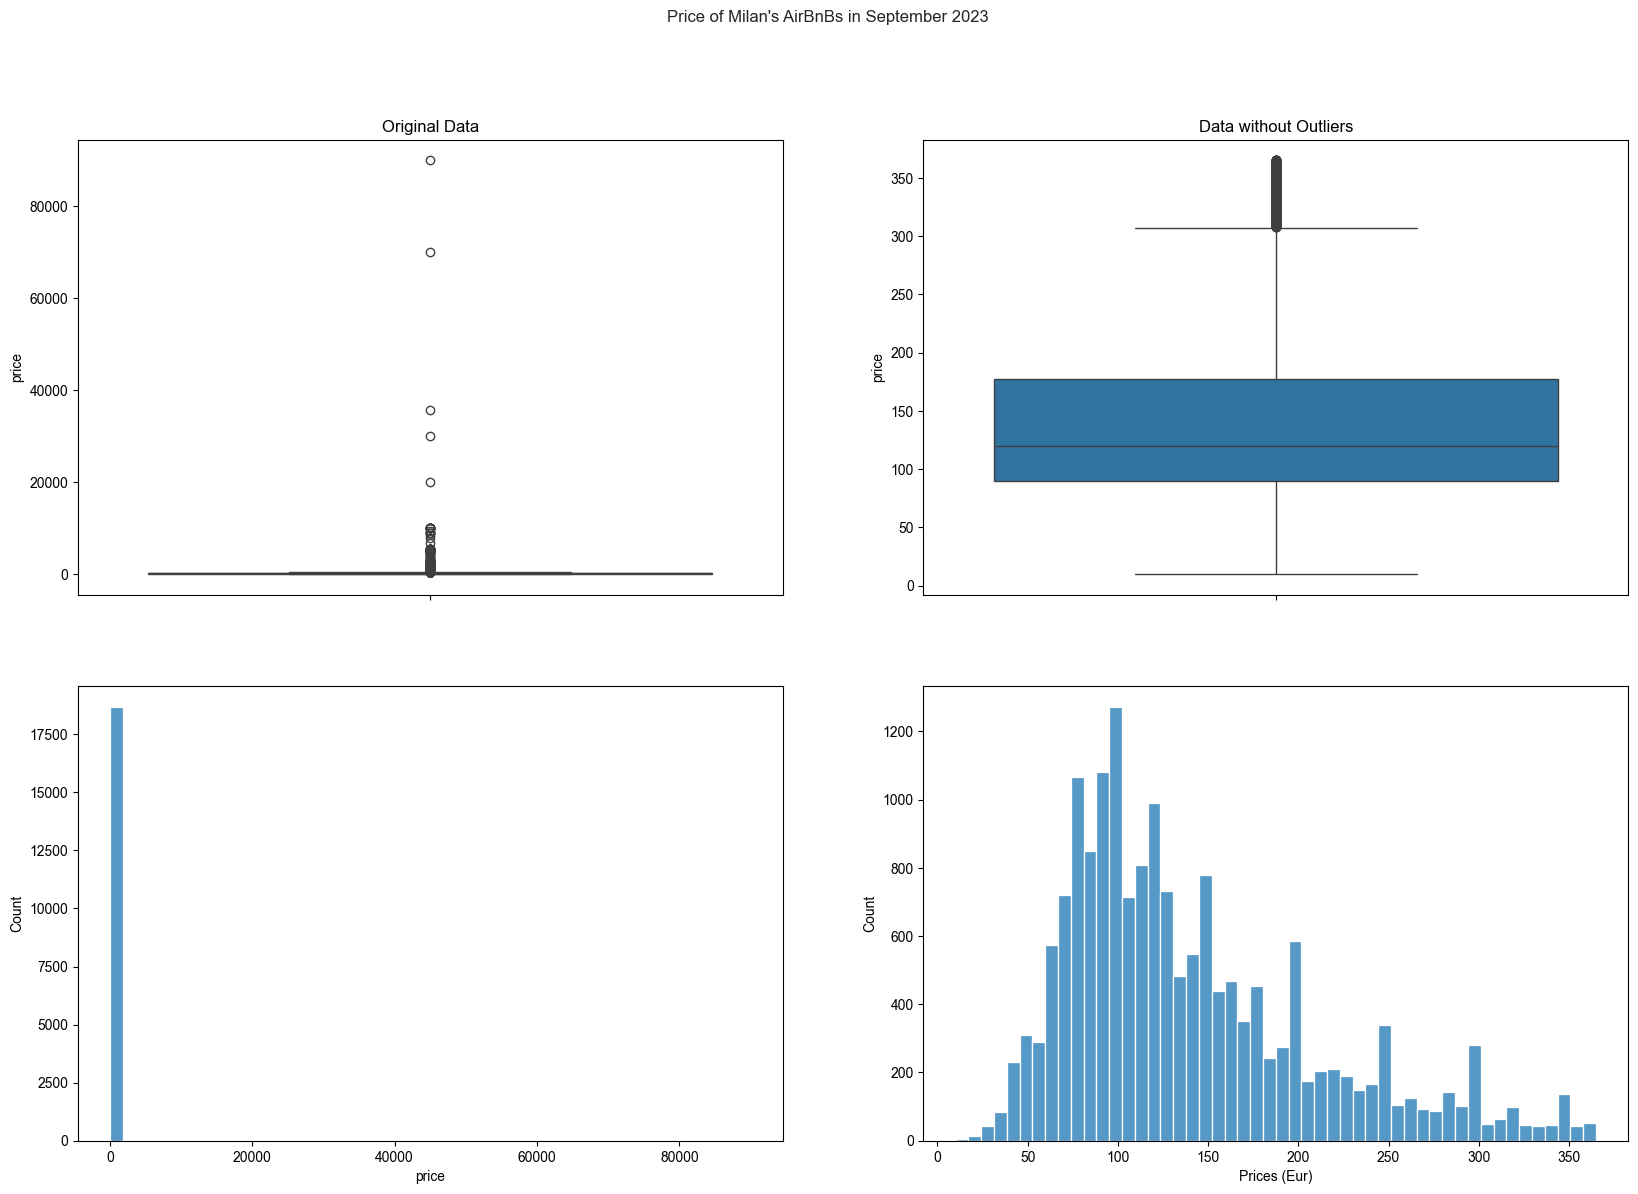

In [20]:
# Define the "subplot".
fig, axes = plt.subplots(
    nrows=2, 
    ncols=2,
    figsize=(20,13)
)

# Set up a stype
sns.set_style("darkgrid")

# Let's add a general title.
fig.suptitle("Price of Milan's AirBnBs in September 2023")

# Add subtitles to each subplot
axes[0,0].set_title("Original Data")
axes[0,1].set_title("Data without Outliers")

sns.boxplot(
    data = listings,
    y = 'price',
    ax = axes[0,0]
)

sns.boxplot(
    data = listings_no_outliers,
    y = 'price',
    ax = axes[0,1]
)

sns.histplot(
    data=listings, 
    x="price",
    bins = 50,
    ax = axes[1,0]
    )


sns.histplot(
    data=listings_no_outliers, 
    x="price",
    bins = 50,
    ax = axes[1,1]
    )

# label axis
_ =  plt.xlabel('Prices (Eur)')
_ = plt.ylabel('Count')

Data looks better now

In [21]:
# Rename datasets for ease
listings_incl_outliers = listings.copy()  # Create a copy to avoid modifying the original DataFrame
listings = listings_no_outliers.copy()  # Create a copy to avoid modifying the original DataFrame

### Calendar

#### Import dataset

In [22]:
calendar = pd.read_csv(parent_folder+'/MI AirBnB - dataset/calendar.csv')

#### Explore data available

In [23]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8824261 entries, 0 to 8824260
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 471.3+ MB


In [24]:
# Price, price_adjusted and date are identified as objects
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,6400,2023-09-14,f,$100.00,$100.00,4.0,5.0
1,6400,2023-09-15,f,$100.00,$100.00,4.0,5.0
2,6400,2023-09-16,f,$100.00,$100.00,4.0,5.0
3,6400,2023-09-17,f,$100.00,$100.00,4.0,5.0
4,6400,2023-09-18,f,$100.00,$100.00,4.0,5.0


#### Unique identifiers
This case probably not
check that listing_id is not missing

In [25]:
calendar[calendar['listing_id'].isna()]

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights


No obs with missing id - good

In [26]:
calendar['listing_id'].nunique()

24177

#### Missing values

In [27]:
columns_with_na = calendar.columns[calendar.isna().any()]

print(columns_with_na)

Index(['price', 'adjusted_price', 'minimum_nights', 'maximum_nights'], dtype='object')


##### Drop fully missing variables

In [28]:
calendar = calendar.dropna(axis=1, how='all')
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8824261 entries, 0 to 8824260
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 471.3+ MB


calendar.info() shows that no variable was fully missing.
However, some variables have na values(). we explore them

##### Explore other variables that contain NAs

look at how many observations are missing

In [29]:
calendar[columns_with_na].isna().sum()

price             171
adjusted_price    171
minimum_nights     15
maximum_nights     15
dtype: int64

a relatively small amount of observations have nas.
we drop those rows with NA price

In [30]:
calendar = calendar.dropna(subset=['price'])

In [31]:
calendar[columns_with_na].isna().sum()

price              0
adjusted_price     0
minimum_nights    15
maximum_nights    15
dtype: int64

same as price_adj - all good now

#### Format variables

price and date variables need formatting

In [32]:
calendar['price'] = calendar['price'].replace('[$,]', '', regex=True).astype(float)
calendar['adjusted_price'] = calendar['adjusted_price'].replace('[$,]', '', regex=True).astype(float)
calendar['date'] = pd.to_datetime(calendar['date'], format = "%Y-%m-%d")
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8824090 entries, 0 to 8824260
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           float64       
 4   adjusted_price  float64       
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 538.6+ MB


calendar.info()shows that the conversion worked

[data cleaning done - for now]

#### Outliers
We apply the same methodology

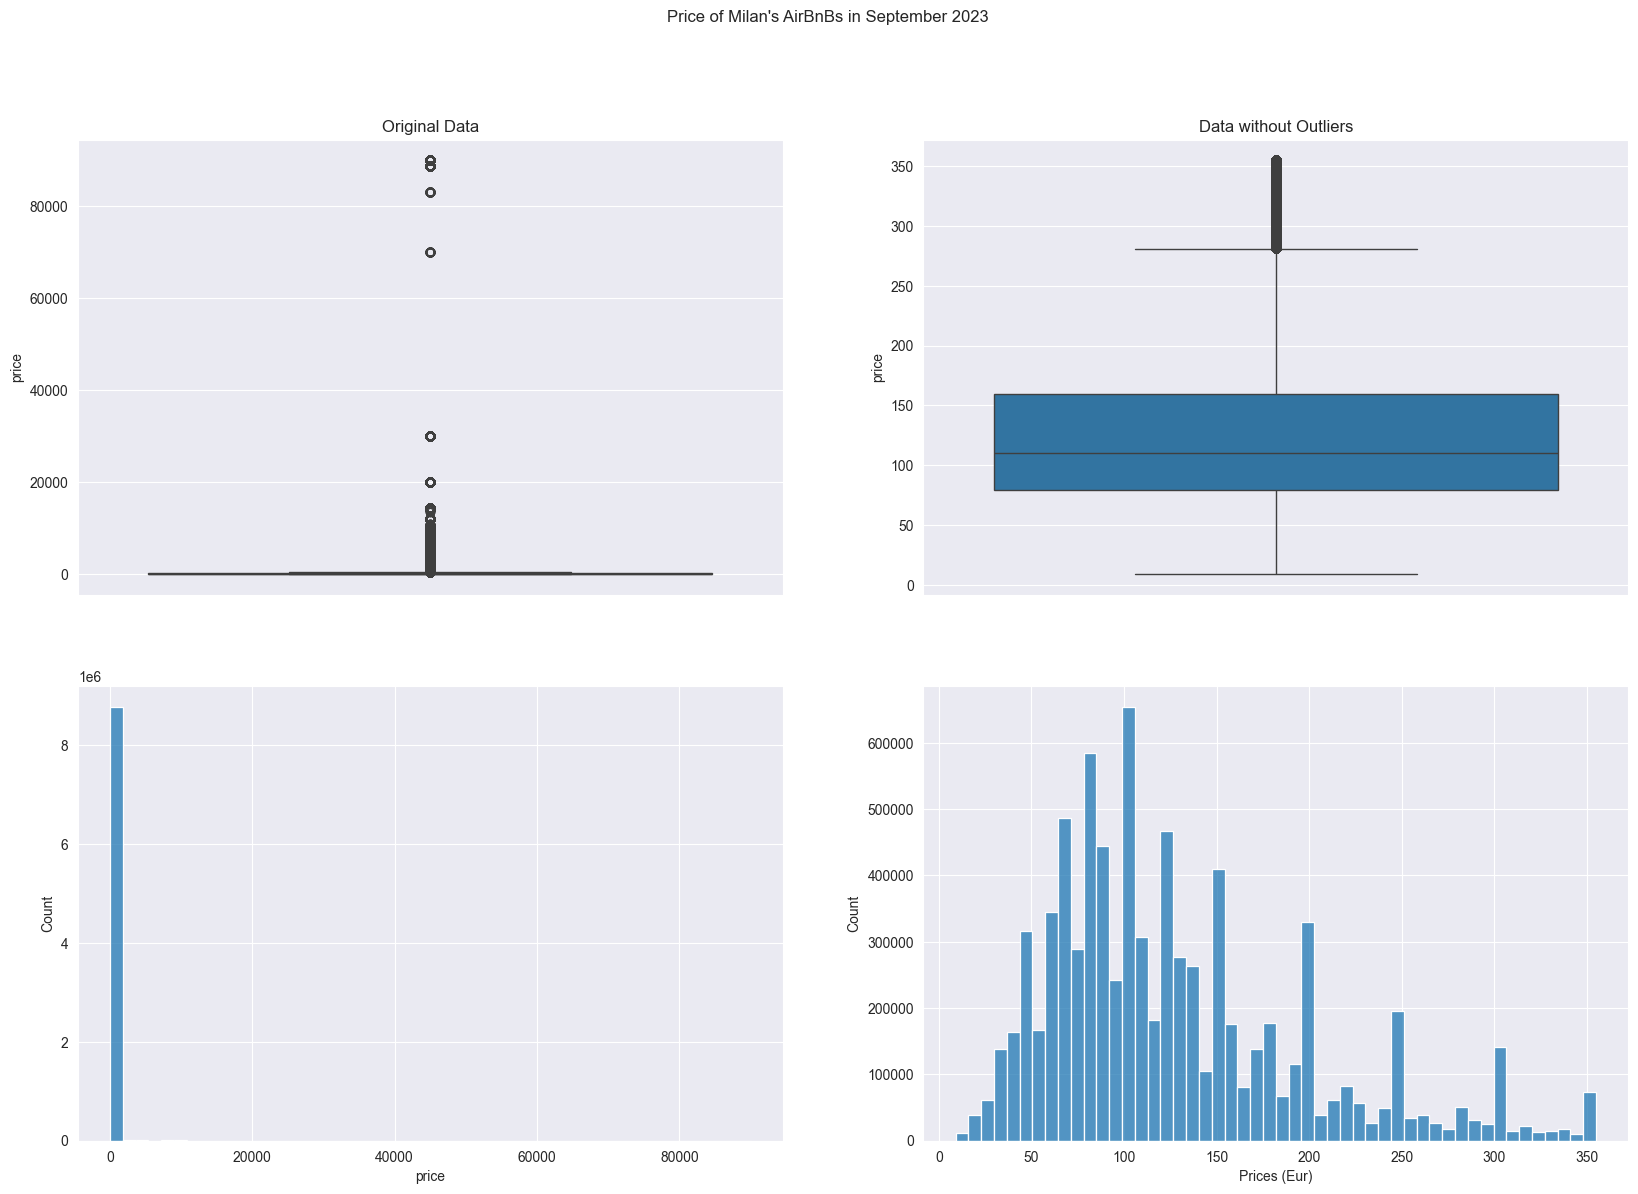

In [33]:
# Calculate the IQR (Interquartile Range)
Q1 = calendar['price'].quantile(0.25)
Q3 = calendar['price'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to exclude outliers
calendar_no_outliers = calendar[(calendar['price'] >= lower_bound) & (calendar['price'] <= upper_bound)]

# Define the "subplot".
fig, axes = plt.subplots(
    nrows=2, 
    ncols=2,
    figsize=(20,13)
)

# Set up a stype
sns.set_style("darkgrid")

# Let's add a general title.
fig.suptitle("Price of Milan's AirBnBs in September 2023")

# Add subtitles to each subplot
axes[0,0].set_title("Original Data")
axes[0,1].set_title("Data without Outliers")

sns.boxplot(
    data = calendar,
    y = 'price',
    ax = axes[0,0]
)

sns.boxplot(
    data = calendar_no_outliers,
    y = 'price',
    ax = axes[0,1]
)

sns.histplot(
    data=calendar, 
    x="price",
    bins = 50,
    ax = axes[1,0]
    )


sns.histplot(
    data=calendar_no_outliers, 
    x="price",
    bins = 50,
    ax = axes[1,1]
    )

# label axis
_ =  plt.xlabel('Prices (Eur)')
_ = plt.ylabel('Count')

## Section 2: Merge datasets

merge on variable listin_id

In [34]:
#first rename
listings = listings.rename(columns={'id': 'listing_id'})

mi_listings = pd.merge(listings, calendar, on='listing_id', how='outer', indicator=True)

how many observations were in common?
compare number of unique ids in the two datasets with those in the initial ones
mi_listings willhave same as listings
what about calendar?

In [35]:
mi_listings['_merge'].value_counts()

_merge
both          6335507
right_only    2488583
left_only           0
Name: count, dtype: int64

keep only vars in common`

In [36]:
# Extract calendar only data
right_only_data = mi_listings[mi_listings['_merge'] == 'right_only']['listing_id']
mi_listings = mi_listings[mi_listings['_merge'] == 'both']

### Cross checks

The additional listings in calendar are those of the observations we dropped with 0 bedrooms?
we check this comparing listings_no_bedroom and calendar

In [37]:
listings_no_bedroom = listings_no_bedroom.rename(columns={'id': 'listing_id'})
listings_no_bedroom_calendar = pd.merge(
    listings_no_bedroom['listing_id'], right_only_data,
    on = 'listing_id', how ='outer', indicator = True
    )

In [38]:
listings_no_bedroom_calendar['_merge'].value_counts()

_merge
both          1981598
right_only     506985
left_only           0
Name: count, dtype: int64

conclusion: ids dropped bc of no bedrooms  
same things with code below:
[listings_2 = listings_2.rename(columns = {'id':'listing_id'})
merge = pd.merge(
    listings_2['listing_id'], calendar,
    on = 'listing_id', how ='outer', indicator = True
    )
    listings_2 = pd.read_csv(parent_folder+'/MI AirBnB - dataset/listings.csv', delimiter = ',')

    merge['_merge'].unique()
    
    ]

## Section 3: Exploratory data analysis

### Local distribution of listings

How are distributed?
- hist of neighbourhoods and ids  
- map

In [39]:
listings['neighbourhood_cleansed'].value_counts()

neighbourhood_cleansed
BUENOS AIRES - VENEZIA    1312
DUOMO                      889
SARPI                      837
NAVIGLI                    749
LORETO                     732
                          ... 
MUGGIANO                     4
PARCO AGRICOLO SUD           3
SACCO                        3
PARCO NORD                   1
RONCHETTO DELLE RANE         1
Name: count, Length: 86, dtype: int64

In [40]:
# there are too many categories to do a countplot chart
# sns.countplot(
#     data=listings,
#     x='neighbourhood_cleansed')

In [41]:
# Import neighbourhoods
geojson_path = parent_folder+'/MI AirBnB - dataset/neighbourhoods.geojson'

In [42]:
# create summary table
neighborhood_counts = listings['neighbourhood_cleansed'].value_counts().reset_index()
neighborhood_counts.columns = ['neighbourhood', 'listing_count']

In [64]:
median_latitude = listings['latitude'].median()
median_longitude = listings['longitude'].median()

milan_map = folium.Map(
    # starting location
    location = [median_latitude, median_longitude],
    zoom_start = 10.5,
    tiles = 'OpenStreetMap'
)
milan_map

cp = folium.Choropleth(
    geo_data=geojson_path,
    data=neighborhood_counts,
    columns=['neighbourhood', 'listing_count'],
    key_on='feature.properties.neighbourhood',  # GeoJSON property for matching
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Listings',
    
    highlight= True,
    nan_fill_color="grey",
    name='Number of listings'
).add_to(milan_map)

# creating a state indexed version of the dataframe so we can lookup values
state_data_indexed = neighborhood_counts.set_index('neighbourhood')

# looping thru the geojson object and adding a new property(unemployment)
# and assigning a value from our dataframe
for s in cp.geojson.data['features']:
    #print(s['properties'])
    #print(s['properties']['neighbourhood'])
    try: 
        #print(state_data_indexed.loc[s['properties']['neighbourhood'], 'listing_count'])
        s['properties']['listing_count'] = int(state_data_indexed.loc[s['properties']['neighbourhood'], 'listing_count'])
        #print(s['properties']['listing_count'])
    except:
        s['properties']['listing_count'] = 0
    #print(s['properties'])

folium.GeoJsonTooltip(
    fields=['neighbourhood', 'listing_count'],
    aliases=['Neighborhood', 'Listings'],
    labels=True,
    sticky=True,
    style= "background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"
).add_to(cp.geojson)

# Note the tooltip doesn't work
milan_map

The neighbourhoods with most listings are 
BUENOS AIRES - VENEZIA	1312
1	DUOMO	889
2	SARPI	837
3	NAVIGLI	749
4	LORETO	732

Explore price

In [44]:
neighborhood_counts
# Sort the DataFrame by 'listing_count' in descending order
neighborhood_counts = neighborhood_counts.sort_values(by='listing_count', ascending=False)

neighborhood_counts['top_20'] = 0
neighborhood_counts.loc[:19, 'top_20'] = 1

neighborhood_counts['grouped_neighbourhood'] = neighborhood_counts.apply(
    lambda row: row['neighbourhood'] if row['top_20'] == 1 
    else 'Other', axis=1)

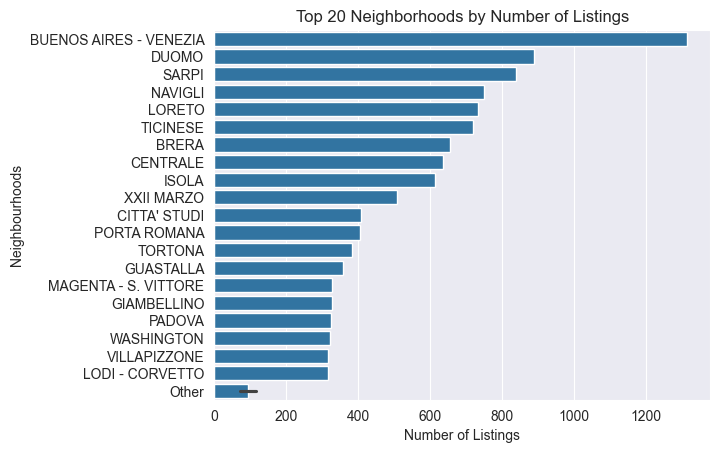

In [45]:
_ = sns.barplot(
    data = neighborhood_counts,
    y = 'grouped_neighbourhood',
    x = 'listing_count'
)
_ = plt.xlabel('Number of Listings')
_ = plt.ylabel('Neighbourhoods')
_ = plt.title('Top 20 Neighborhoods by Number of Listings')
plt.show()

### Price distribution

In [46]:
neighborhood_avg_price = listings.groupby('neighbourhood_cleansed')['price'].mean().reset_index()
neighborhood_avg_price.columns = ['neighbourhood', 'avg_price']
neighborhood_avg_price

,neighbourhood,avg_price
0,ADRIANO,110.655172
1,AFFORI,114.408805
2,BAGGIO,84.081633
3,BANDE NERE,116.958904
4,BARONA,107.222222
...,...,...
81,VIALE MONZA,110.015267
82,VIGENTINA,143.365079
83,VILLAPIZZONE,107.110410
84,WASHINGTON,135.656347


In [65]:
p_prices = folium.Choropleth(
    geo_data=geojson_path,
    data=neighborhood_avg_price,
    columns=['neighbourhood', 'avg_price'],
    key_on='feature.properties.neighbourhood',  # GeoJSON property for matching
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average price',
    
    highlight= True,
    nan_fill_color="grey",
    name='Average price'
).add_to(milan_map)

# creating a state indexed version of the dataframe so we can lookup values
price_data_indexed = neighborhood_avg_price.set_index('neighbourhood')

# looping thru the geojson object and adding a new property(unemployment)
# and assigning a value from our dataframe
for s in p_prices.geojson.data['features']:
    #print(s['properties'])
    #print(s['properties']['neighbourhood'])
    try: 
        #print(state_data_indexed.loc[s['properties']['neighbourhood'], 'listing_count'])
        s['properties']['average_price'] = int(price_data_indexed.loc[s['properties']['neighbourhood'], 'avg_price'])
        #print(s['properties']['listing_count'])
    except:
        s['properties']['average_price'] = 0
    #print(s['properties'])

folium.GeoJsonTooltip(
    fields=['neighbourhood', 'average_price'],
    aliases=['Neighborhood', 'Average price'],
    labels=True,
    sticky=True,
    style= "background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"
).add_to(p_prices.geojson)

folium.LayerControl().add_to(milan_map)

milan_map

In [48]:
neighborhood_avg_price = pd.merge(
    neighborhood_avg_price,
    neighborhood_counts,
    on = 'neighbourhood',
    how = 'left'
)

neighborhood_avg_price.sort_values(by = 'listing_count', ascending=False)


,neighbourhood,avg_price,listing_count,top_20,grouped_neighbourhood
10,BUENOS AIRES - VENEZIA,151.365854,1312,1,BUENOS AIRES - VENEZIA
19,DUOMO,213.104612,889,1,DUOMO
70,SARPI,148.632019,837,1,SARPI
42,NAVIGLI,145.096128,749,1,NAVIGLI
36,LORETO,120.874317,732,1,LORETO
...,...,...,...,...,...
41,MUGGIANO,104.500000,4,0,Other
69,SACCO,54.000000,3,0,Other
47,PARCO AGRICOLO SUD,102.333333,3,0,Other
65,RONCHETTO DELLE RANE,71.000000,1,0,Other


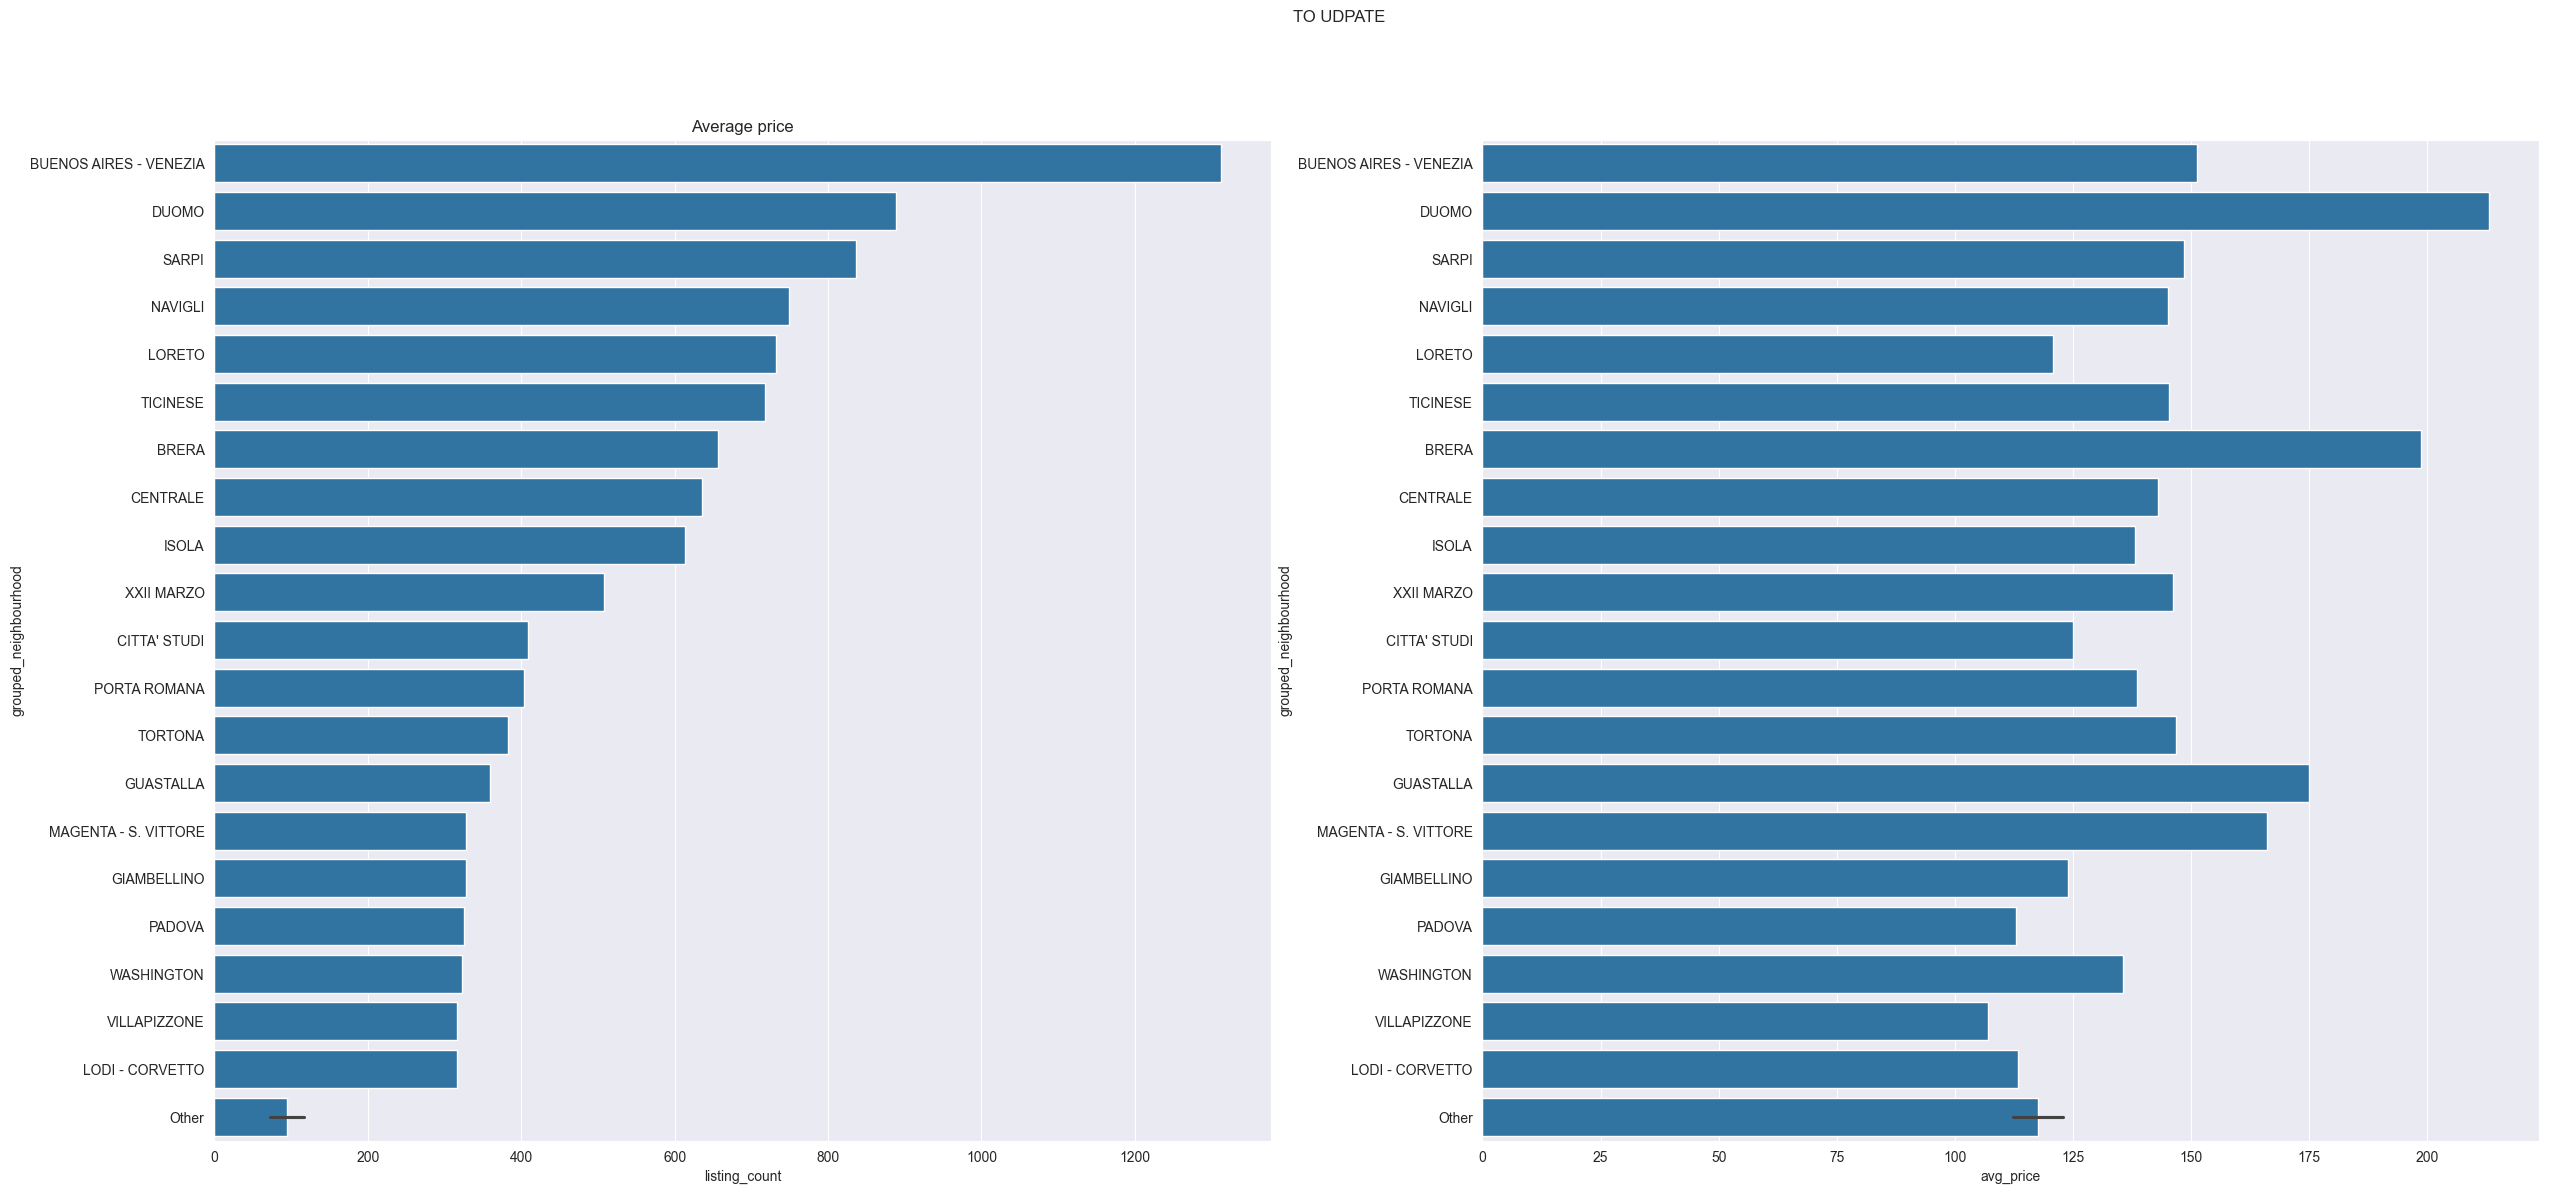

In [49]:
# Define the "subplot".
fig, axes = plt.subplots(
    nrows=1, 
    ncols=2,
    figsize=(30,13)
)

# Set up a stype
sns.set_style("darkgrid")

# Let's add a general title.
fig.suptitle("TO UDPATE")

# Add subtitles to each subplot
axes[0].set_title("Number of listings")
axes[0].set_title("Average price")

sns.barplot(
    data = neighborhood_counts,
    y = 'grouped_neighbourhood',
    x = 'listing_count',
    order = neighborhood_counts.sort_values(
        by = 'listing_count', ascending = False)['grouped_neighbourhood'],
    ax = axes[0]

)

sns.barplot(
    data = neighborhood_avg_price,
    y = 'grouped_neighbourhood',
    x = 'avg_price',
    order = neighborhood_avg_price.sort_values(
        by = 'listing_count', ascending = False)['grouped_neighbourhood'],
    ax = axes[1]
)

plt.show()

### Other determinants of price

In [50]:
listings['bedrooms'].unique()

array([ 1.,  3.,  2.,  4.,  5., 10.,  6., 11.])

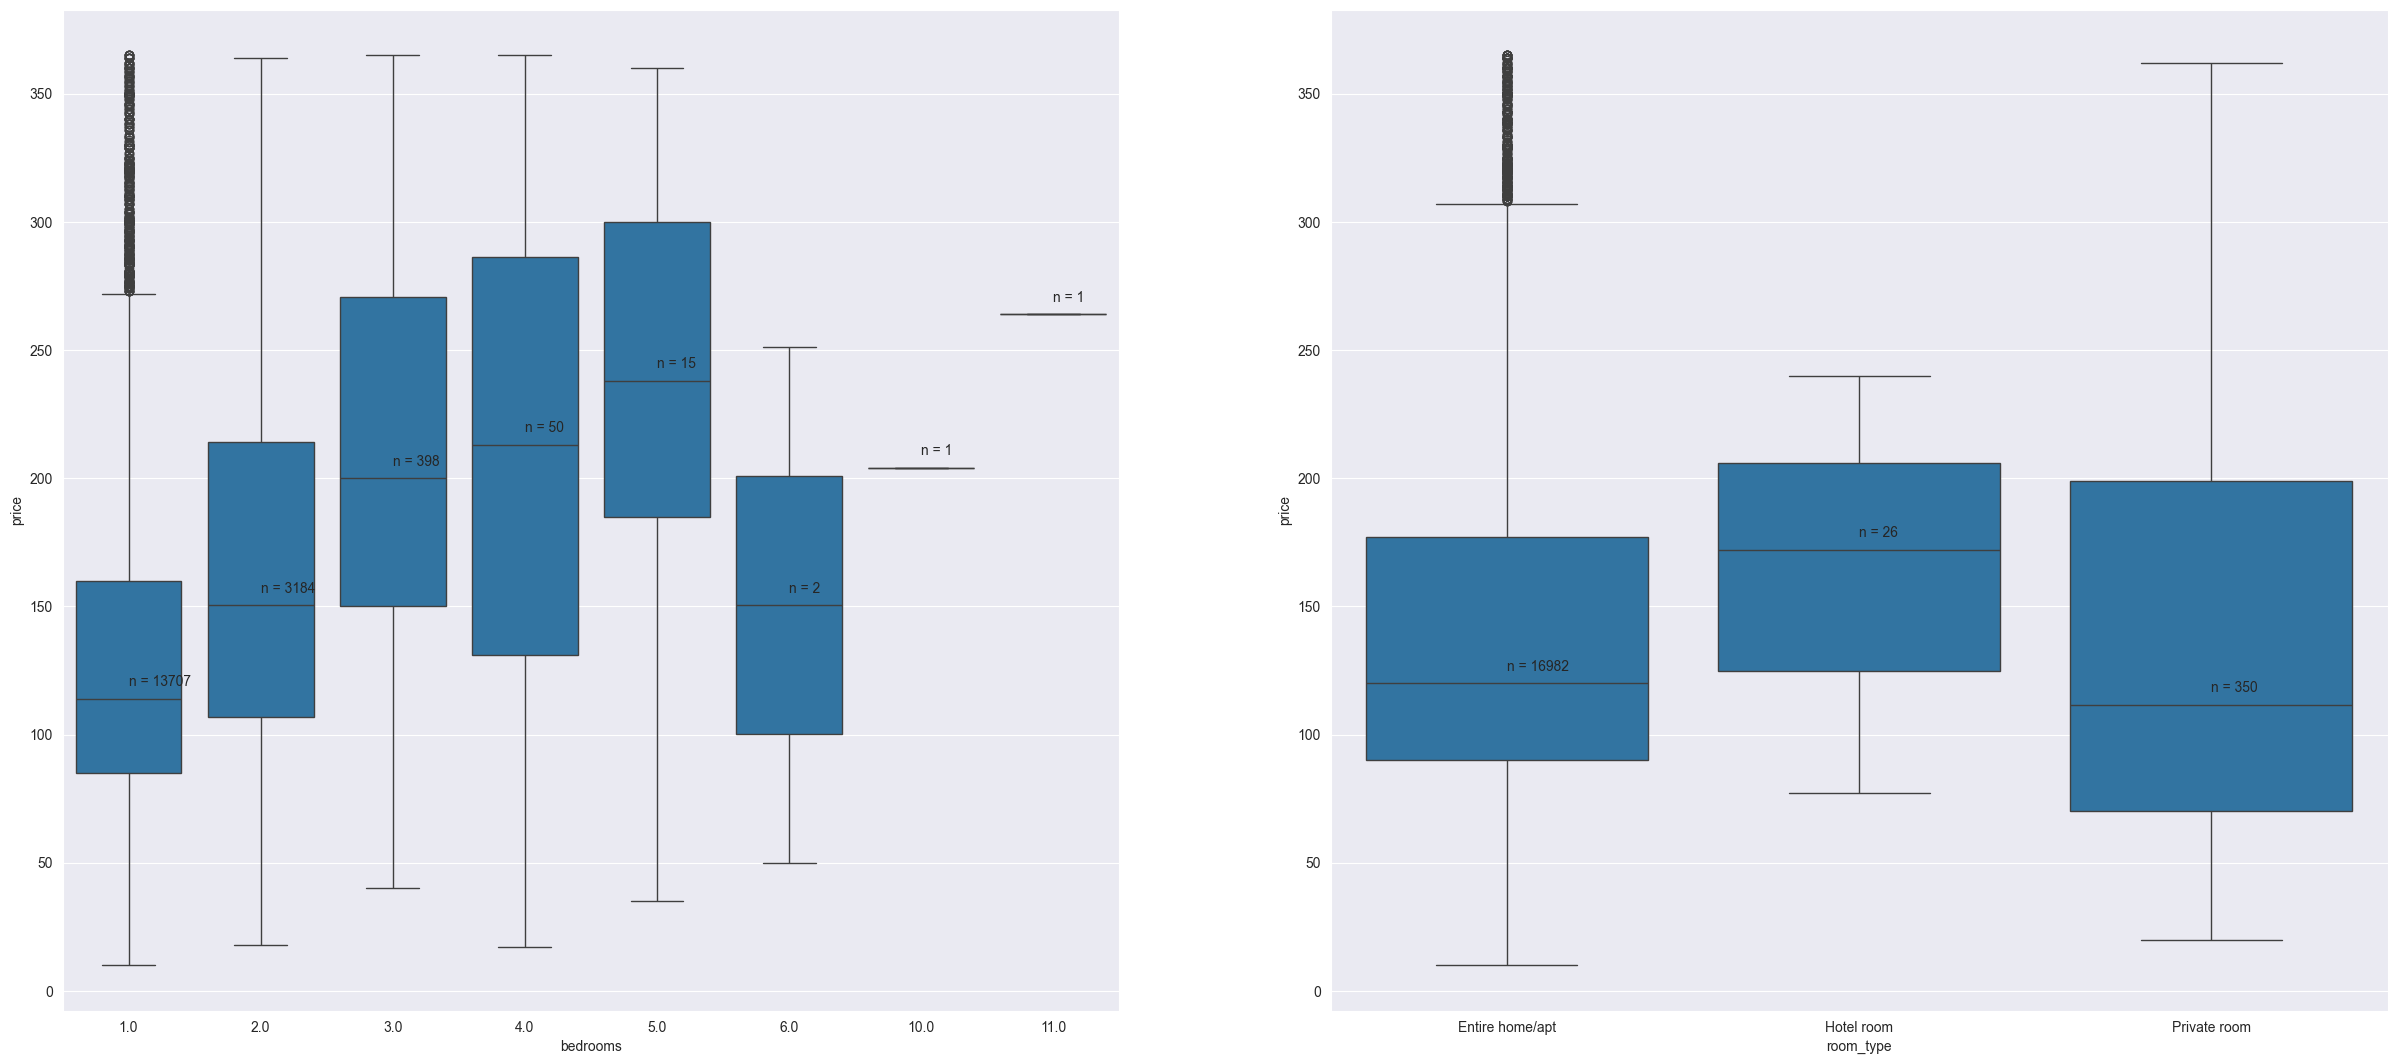

In [51]:
fig, axes = plt.subplots(
    nrows=1, 
    ncols=2,
    figsize=(30,13)
)

#Price by beds
boxplot_axis = sns.boxplot(
    data = listings,
    y = 'price',
    x = 'bedrooms',
    ax = axes[0]
)

x = 0
# Get list of number of bedrooms available
bedrooms_available = np.unique(listings['bedrooms'])

for num_bedrooms in bedrooms_available:
    y = np.median(listings[listings['bedrooms'] == num_bedrooms]['price']) + 5
    nobs = listings[listings['bedrooms'] == num_bedrooms].shape[0]
    text = f"n = {nobs}"
    #print(f"{x} {num_bedrooms} {np.median(listings[listings['bedrooms'] == num_bedrooms]['price'])} {y} {text}")

    boxplot_axis.text(
        x = x,
        y = y,
        s = text
    )
    x +=1

# Get list of number of bedrooms available
bedrooms_available = np.unique(listings['room_type'])
# Price by room type
boxplot_axis = sns.boxplot(
    data = listings,
    y = 'price',
    x = 'room_type',
    ax = axes[1],
    order = bedrooms_available
)

x = 0


for num_bedrooms in bedrooms_available:
    x = np.argmax(bedrooms_available == num_bedrooms)
    y = np.median(listings[listings['room_type'] == num_bedrooms]['price']) + 5
    nobs = listings[listings['room_type'] == num_bedrooms].shape[0]
    text = f"n = {nobs}"
    #print(f"{x} {num_bedrooms} {np.median(listings[listings['room_type'] == num_bedrooms]['price'])} {y} {text}")

    boxplot_axis.text(
        x = x,
        y = y,
        s = text
    )
plt.show()

- first on separate datasets
- what are the min and max data?
- what is the distr of prices of listings?
- have prices changed over time?

### Price and listings over time

In [52]:
mi_listings['date'].describe()

count                          6335507
mean     2024-03-13 12:01:14.385331968
min                2023-09-13 00:00:00
25%                2023-12-13 00:00:00
50%                2024-03-13 00:00:00
75%                2024-06-13 00:00:00
max                2024-09-12 00:00:00
Name: date, dtype: object

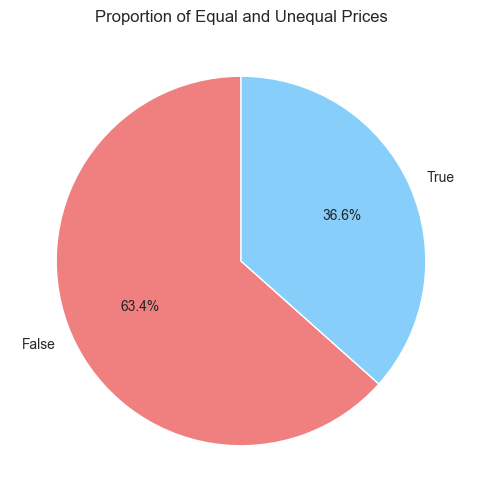

In [53]:
mi_listings['equal_prices'] = mi_listings['price_x'] == mi_listings['price_y']
value_counts = mi_listings['equal_prices'].value_counts(normalize=True)

#
plt.figure(figsize=(6, 6))
plt.pie(
    value_counts, 
    labels=value_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['lightcoral', 'lightskyblue'])
plt.title('Proportion of Equal and Unequal Prices')
plt.show()

<Axes: xlabel='date', ylabel='price_y'>

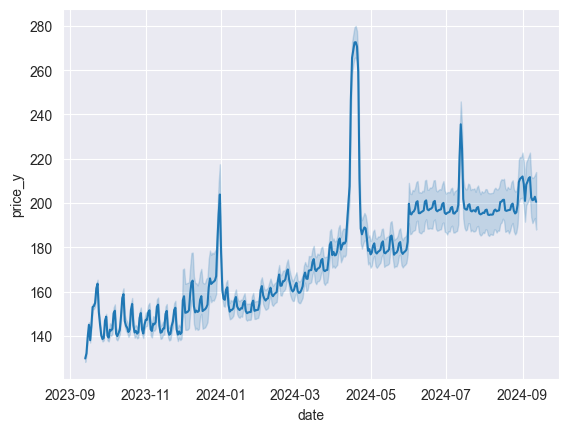

In [54]:
sns.lineplot(
    data = mi_listings,
    x = "date",
    y = "price_y"
)


huge peak in may - salone and summer?